In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/multilevel_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.ppo import PPO
from stable_baselines3.a2c import A2C
import os
from copy import deepcopy

from utils.plot_functions import plot_rl, plot_k_array, plot_learning_tr, plot_actions, plot_rewards
from utils.env_evaluate_functions import eval_actions, eval_model
from utils.data_handling import get_mean_tr_data, get_sar_data, get_min_tr_data, get_max_tr_data

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True

In [3]:
case='case_1'

ppo_1l_dir ='../ppo_multilevel/data/ppo_1l'
ppo_2l_dir = '../ppo_multilevel/data/ppo_2l'
ppo_3l_dir = '../ppo_multilevel/data/ppo_3l'
opt_dir = '../de/case_1'

data_dir = './'+case
os.makedirs(data_dir, exist_ok=True)

# Learning plots

<IPython.core.display.Javascript object>


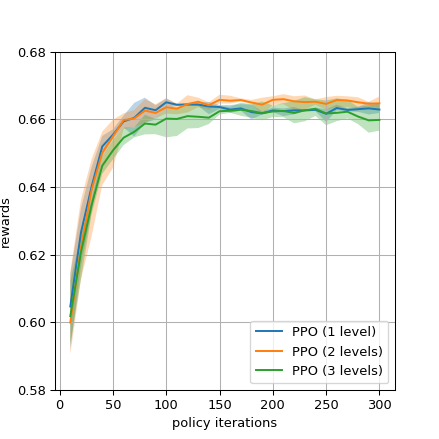

In [4]:
# Learning plot data
_, r_ppo_1l = get_mean_tr_data(ppo_1l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_2l = get_mean_tr_data(ppo_2l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_3l = get_mean_tr_data(ppo_3l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

_, r_ppo_1l_min = get_min_tr_data(ppo_1l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_2l_min = get_min_tr_data(ppo_2l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_3l_min = get_min_tr_data(ppo_3l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

_, r_ppo_1l_max = get_max_tr_data(ppo_1l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_2l_max = get_max_tr_data(ppo_2l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_3l_max = get_max_tr_data(ppo_3l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

# get de benchmark value
opt_array=[]
for i in range(16):
    opt_array.append(np.load(opt_dir+'/ck_max_'+str(i)+'.npy'))

fig, ax = plt.subplots(1,1,figsize=(5,5), sharey=True)
plt.subplots_adjust( bottom=0.2, top=0.8, wspace=None, hspace=None)

p_iter = np.arange(10,310,10)
ax.plot(p_iter, r_ppo_1l, label='PPO (1 level)')
ax.fill_between(p_iter, r_ppo_1l_min, r_ppo_1l_max, alpha=0.3)
ax.plot(p_iter, r_ppo_2l, label='PPO (2 levels)')
ax.fill_between(p_iter, r_ppo_2l_min, r_ppo_2l_max, alpha=0.3)
ax.plot(p_iter, r_ppo_3l, label='PPO (3 levels)')
ax.fill_between(p_iter, r_ppo_3l_min, r_ppo_3l_max, alpha=0.3)
ax.set_xlabel('policy iterations')
ax.set_ylabel('rewards')
ax.set_ylim([0.58,0.68])
ax.grid('on')
ax.legend()
fig.savefig(data_dir+'/'+case+'_r_plot.pdf')

# Training and Evalutation Permeabilities

<IPython.core.display.Javascript object>


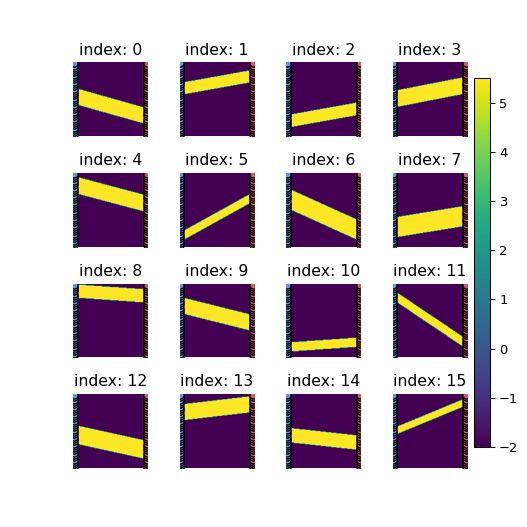

In [5]:
with open('../envs_params/env_data_v1/env_train_dict.pkl', 'rb') as input:
    env_train_dict = pickle.load(input)
fine_level = list(env_train_dict.keys())[-1]
env_train = env_train_dict[fine_level]
k_train = np.load('../envs_params/env_data_v1/k_log_md_train_clustered.npy')
fig = plot_k_array(k_train, env_train.ressim_params.q.copy(), rows=4, cols=4, marker_size=30)
fig.savefig(data_dir+'/'+case+'_k_train.pdf')

<IPython.core.display.Javascript object>


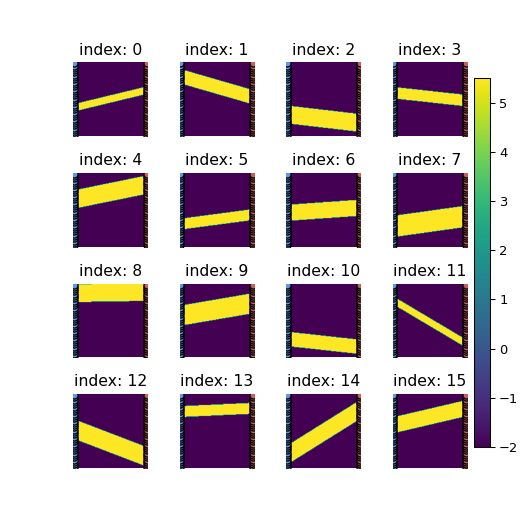

In [6]:
k_eval = np.load('../envs_params/env_data_v1/k_log_md_eval_clustered.npy')
fig = plot_k_array(k_eval, env_train.ressim_params.q.copy(), rows=4, cols=4, marker_size=30)
fig.savefig(data_dir+'/'+case+'_k_eval.pdf')

# Plot results

In [7]:
# data gathering
seed=1
model_ppo_1l = PPO.load(ppo_1l_dir+'/seed_'+str(seed)+'/PPO')
model_ppo_2l = PPO.load(ppo_2l_dir+'/seed_'+str(seed)+'/PPO')
model_ppo_3l = PPO.load(ppo_3l_dir+'/seed_'+str(seed)+'/PPO')

# with open('../envs_params/env_data_v1/env_eval_dict.pkl', 'rb') as input:
#     env_eval_dict = pickle.load(input)
# env_eval = env_eval_dict[fine_level]

k_list = env_train.ressim_params.k_list
envs = []
for k in k_list:
    env_ = deepcopy(env_train)
    env_.set_k(np.array([k]))
    envs.append(env_)
    
models=[model_ppo_1l, model_ppo_2l, model_ppo_3l]
model_names = ['PPO (1 level)', 'PPO (2 levels)', 'PPO (3 levels)']

s_array_eval, a_array_eval, r_array_eval, case_names_eval = get_sar_data(envs, list(range(16)),
                                                                         opt_dir,
                                                                         models, model_names, model_base_steps = 0)

/data/ad181/RemoteDir/multilevel_ppo/stable_baselines_mlppo/stable_baselines3/common/envs/multi_level_model/level_mapping_functions.py:43: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


<IPython.core.display.Javascript object>


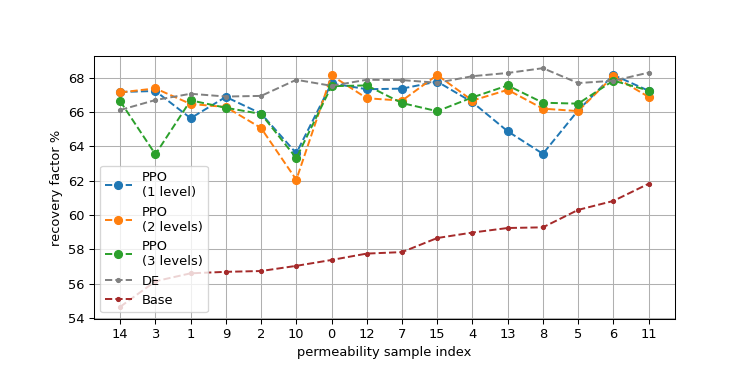

In [8]:
# plot rewards (oil recovery)
fig, axs = plt.subplots(1,1,figsize=(8,4))
plt.subplots_adjust(left=None,bottom=0.15,right=None,top=0.85,wspace=0.1,hspace=0.1)
plot_rewards(r_array_eval, axs, model_names)
fig.savefig(data_dir+'/'+case+'_r_eval.pdf')

<IPython.core.display.Javascript object>


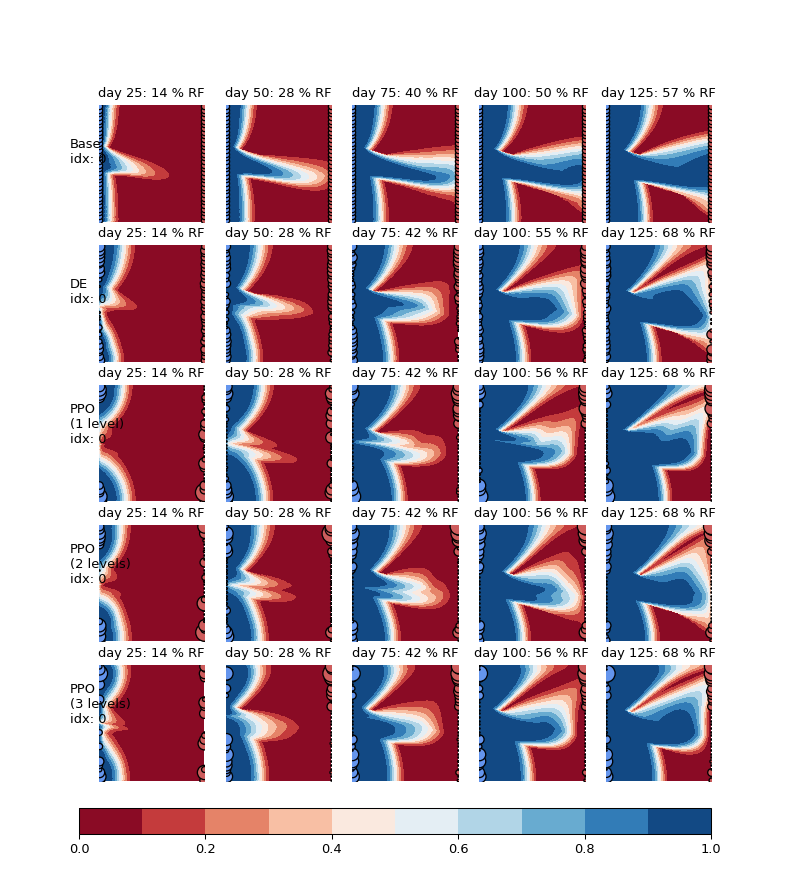

<IPython.core.display.Javascript object>


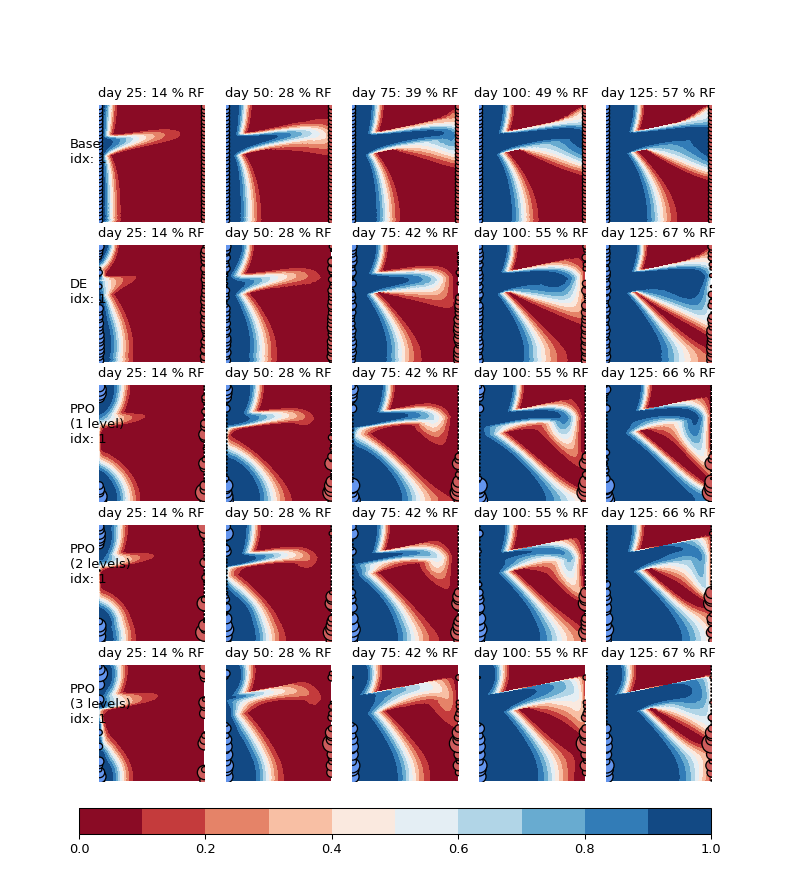

<IPython.core.display.Javascript object>


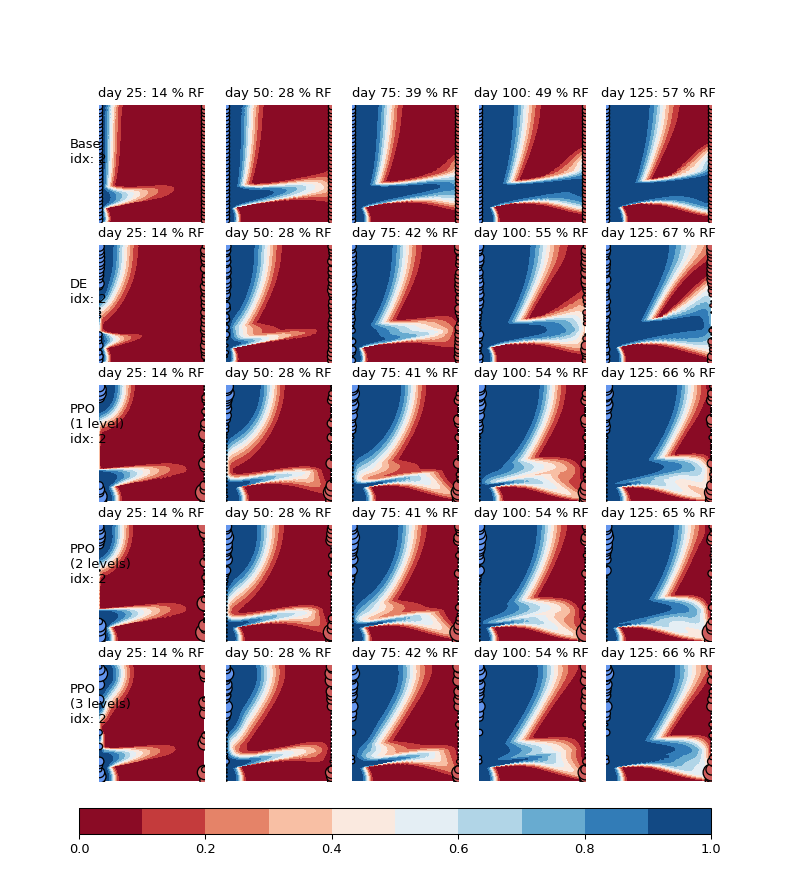

<IPython.core.display.Javascript object>


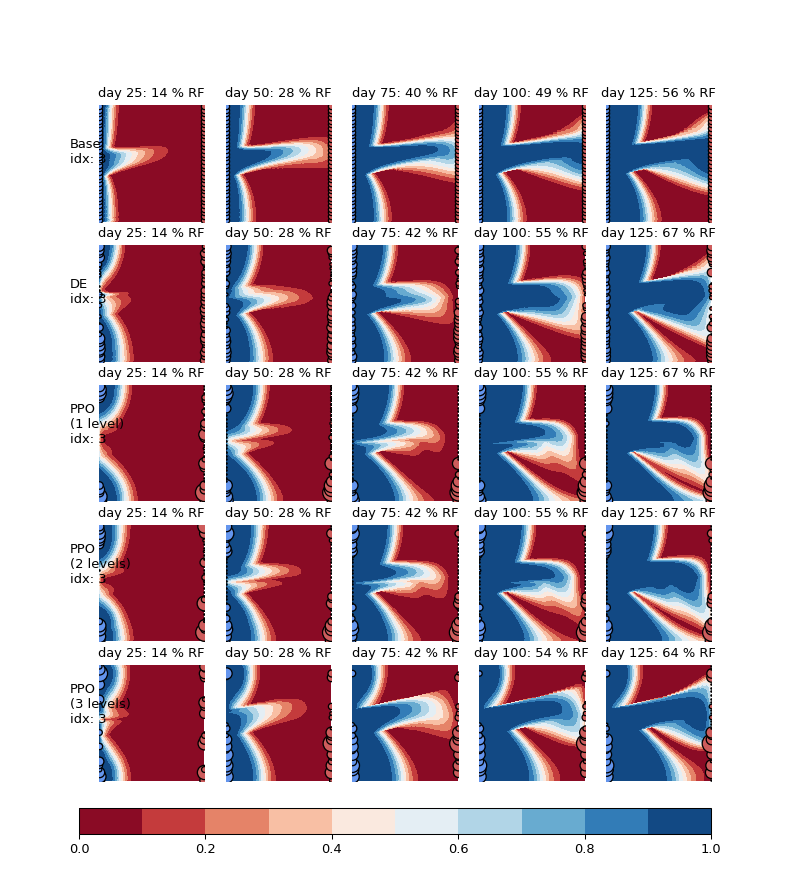

<IPython.core.display.Javascript object>


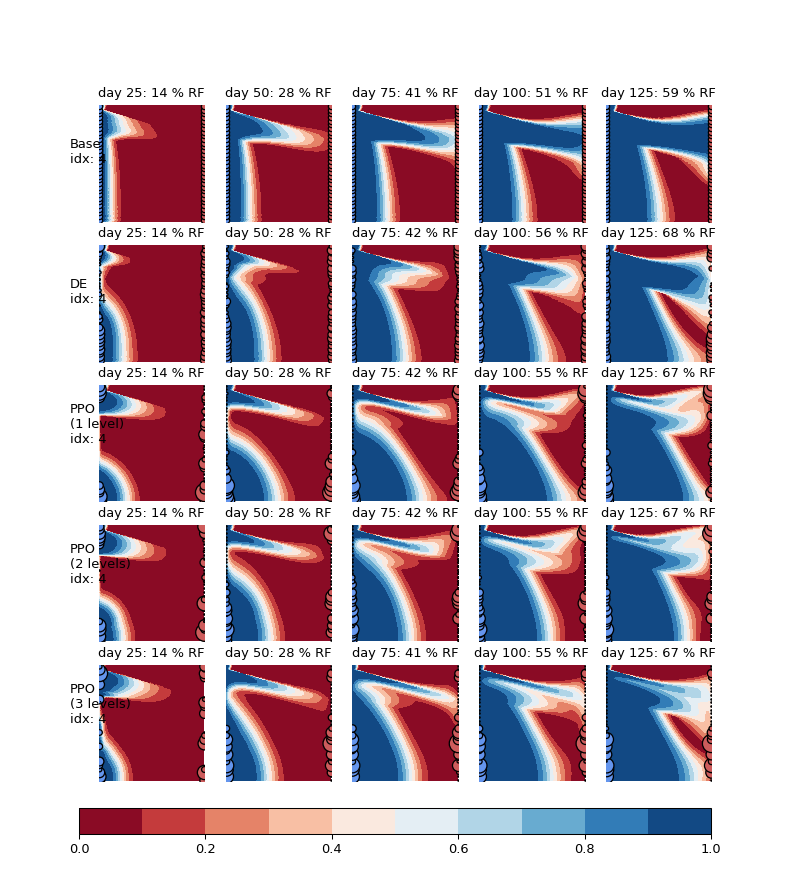

<IPython.core.display.Javascript object>


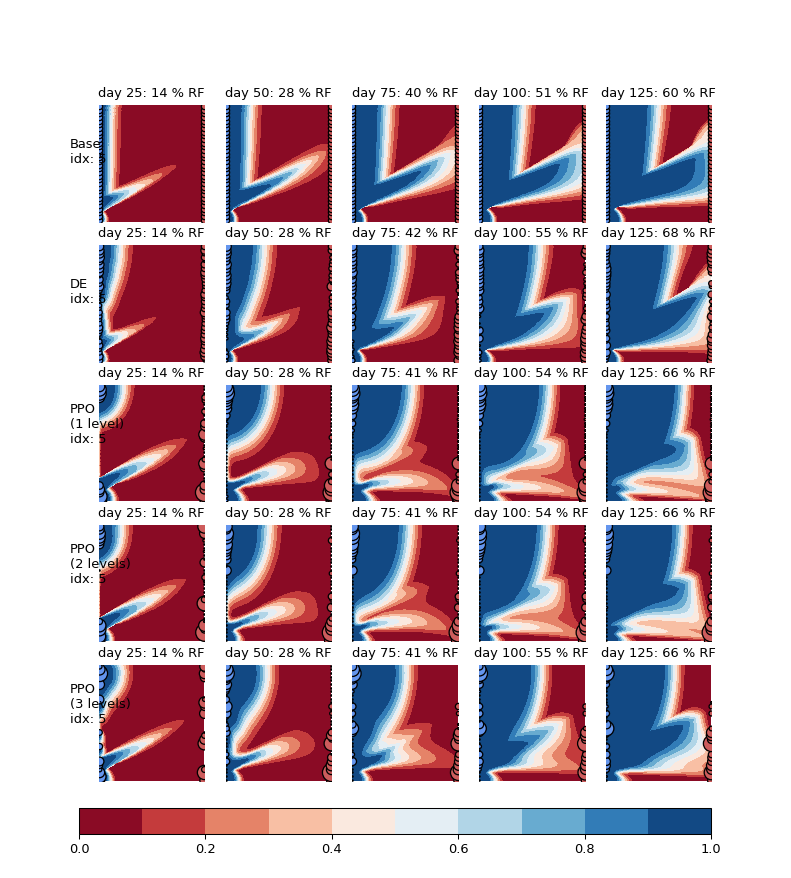

<IPython.core.display.Javascript object>


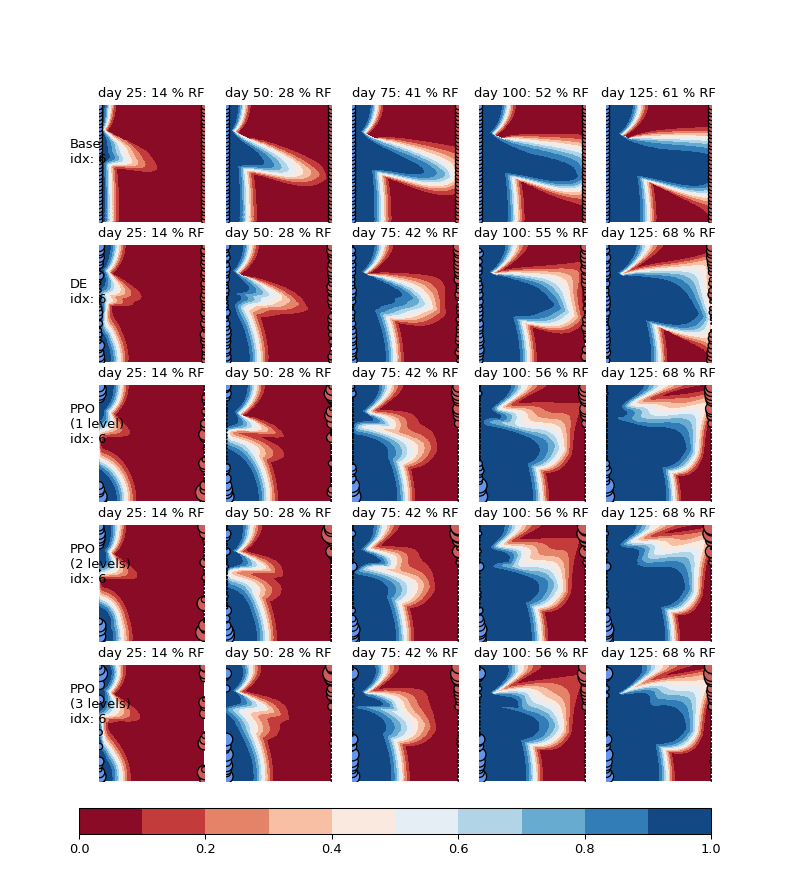

<IPython.core.display.Javascript object>


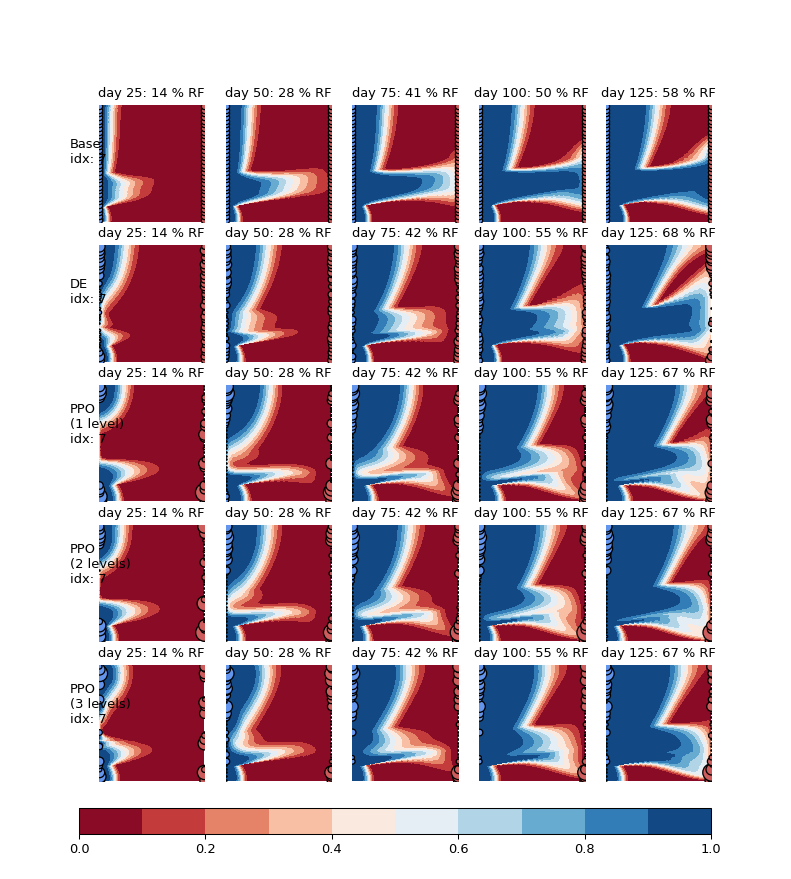

<IPython.core.display.Javascript object>


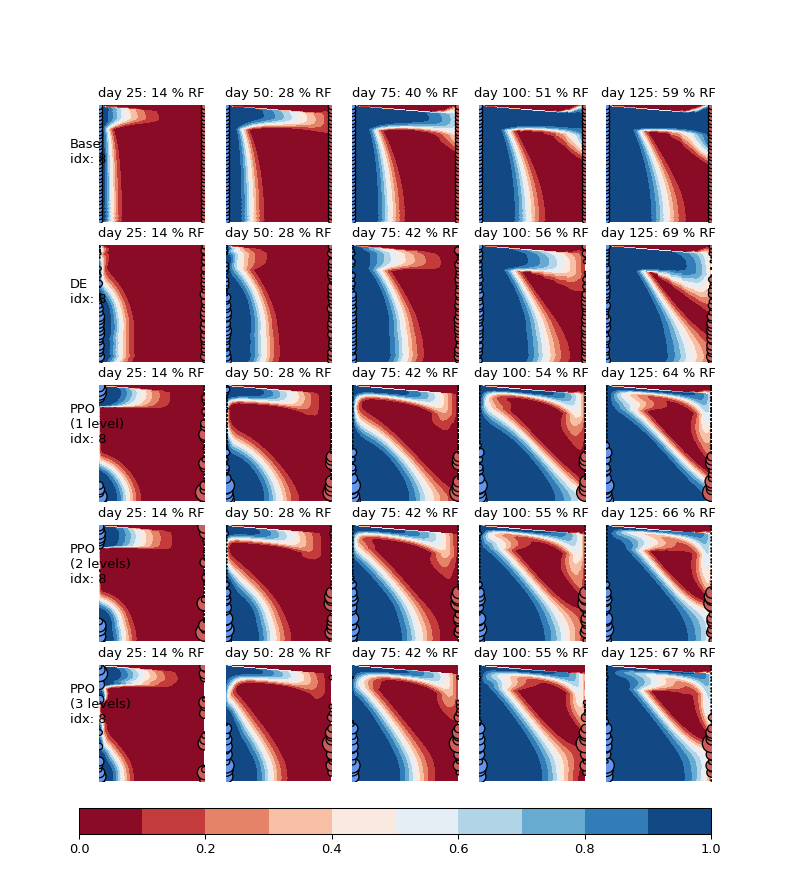

<IPython.core.display.Javascript object>


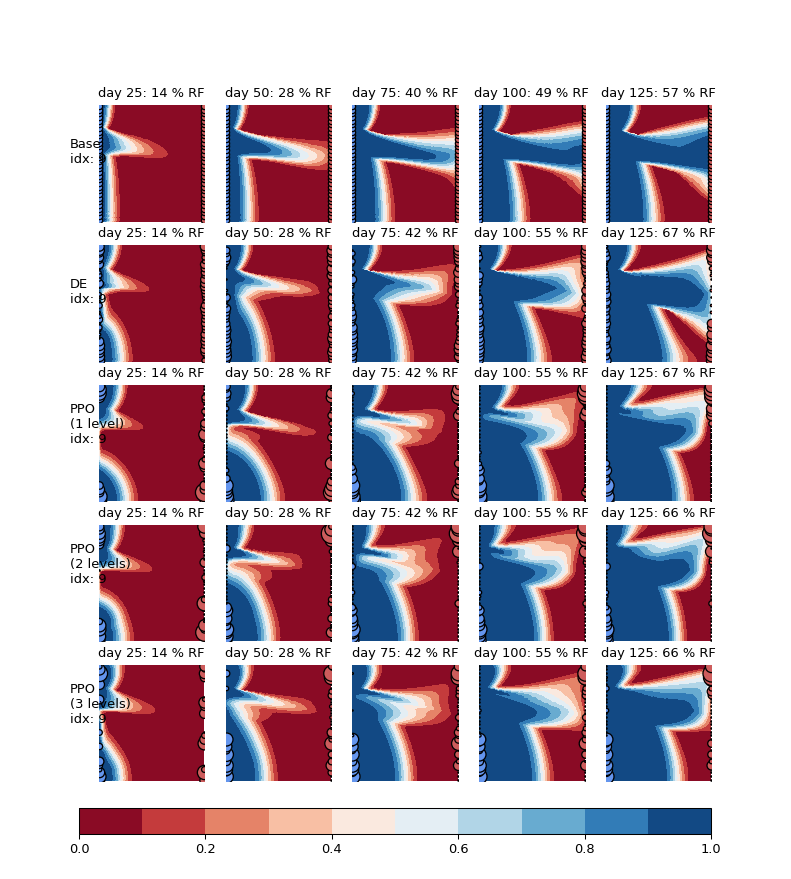

<IPython.core.display.Javascript object>


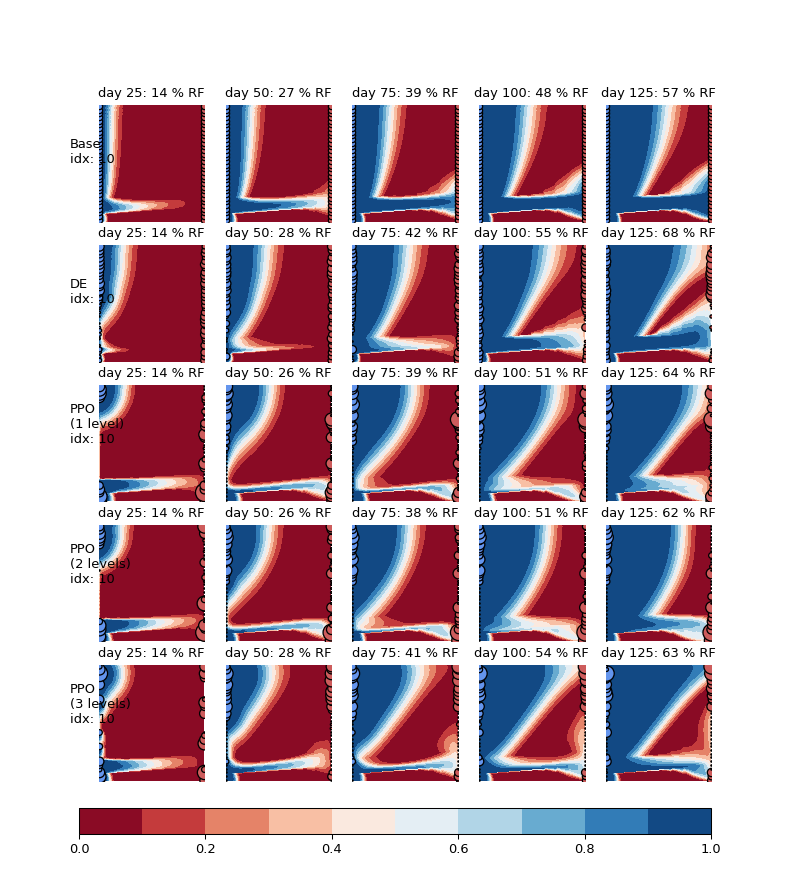

<IPython.core.display.Javascript object>


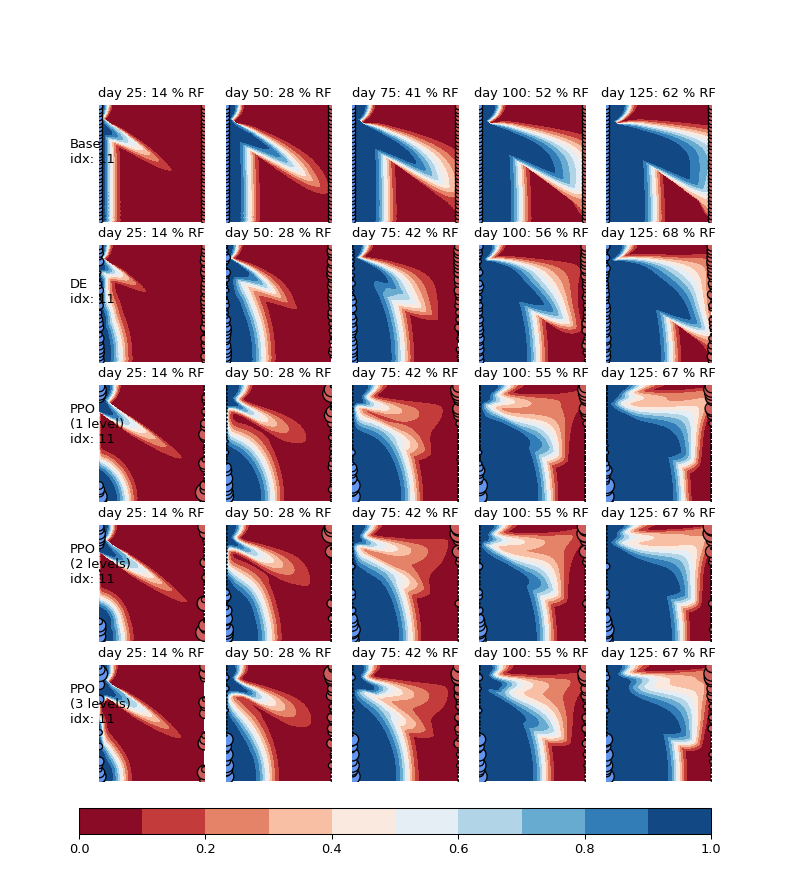

<IPython.core.display.Javascript object>


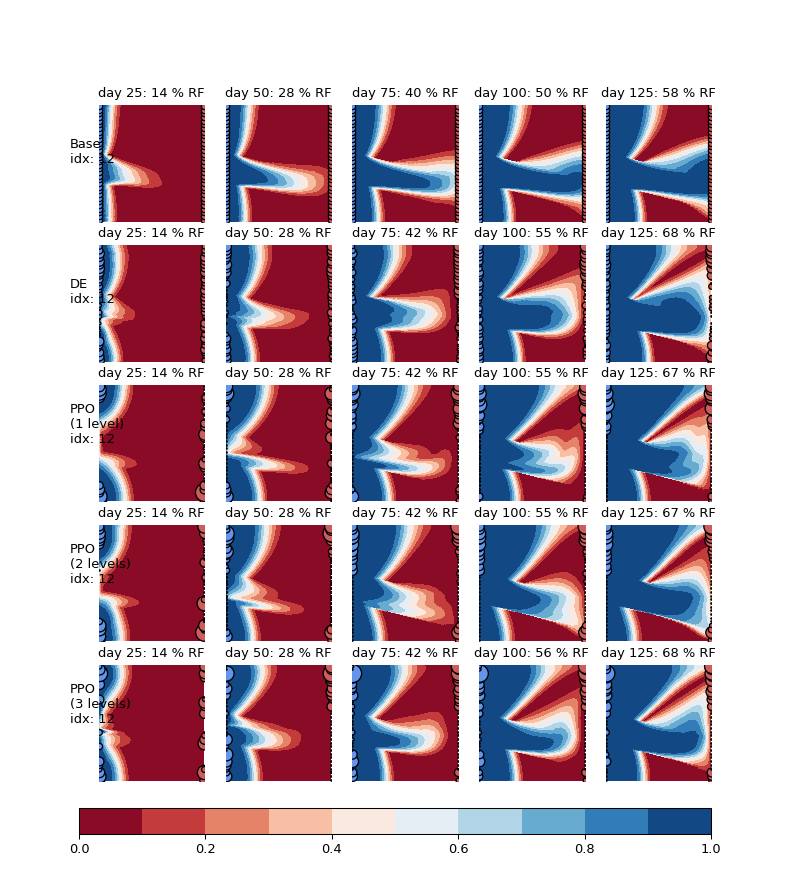

<IPython.core.display.Javascript object>


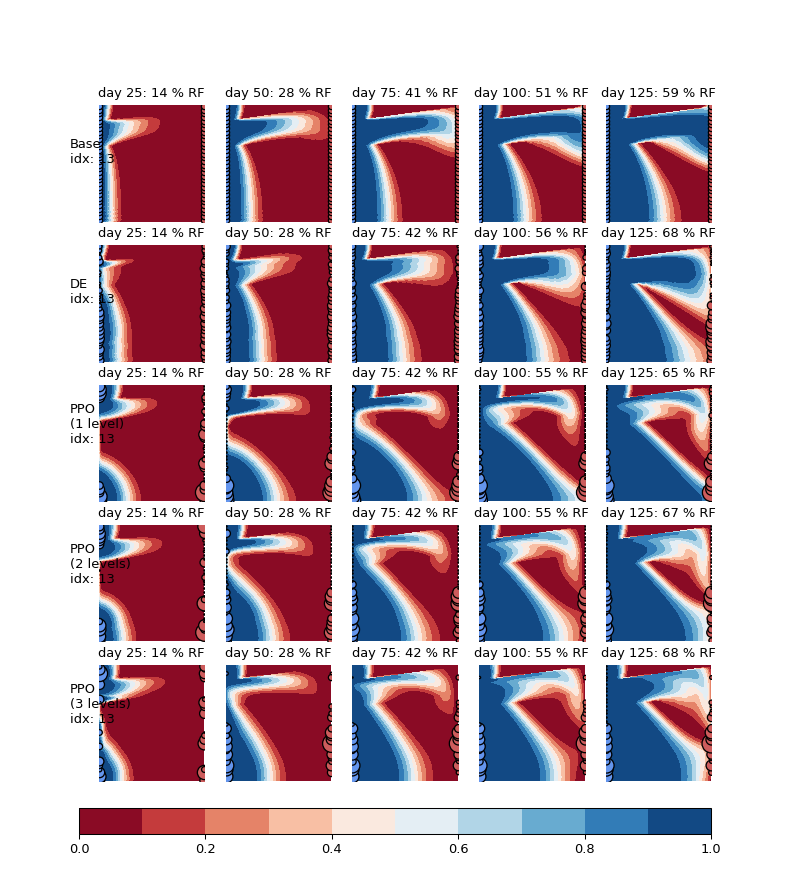

<IPython.core.display.Javascript object>


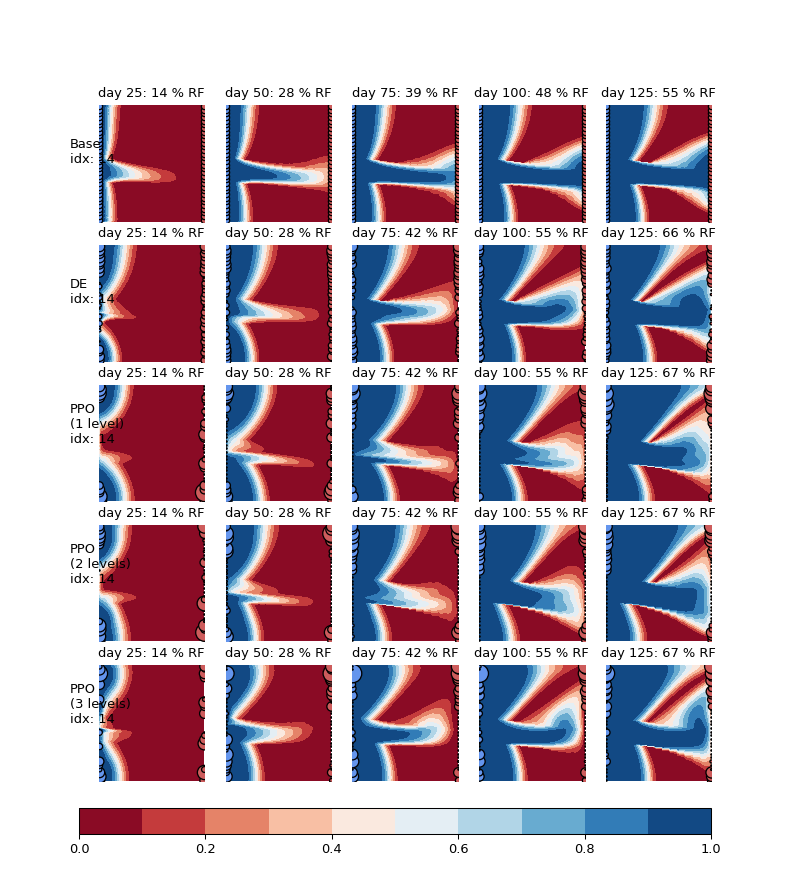

<IPython.core.display.Javascript object>


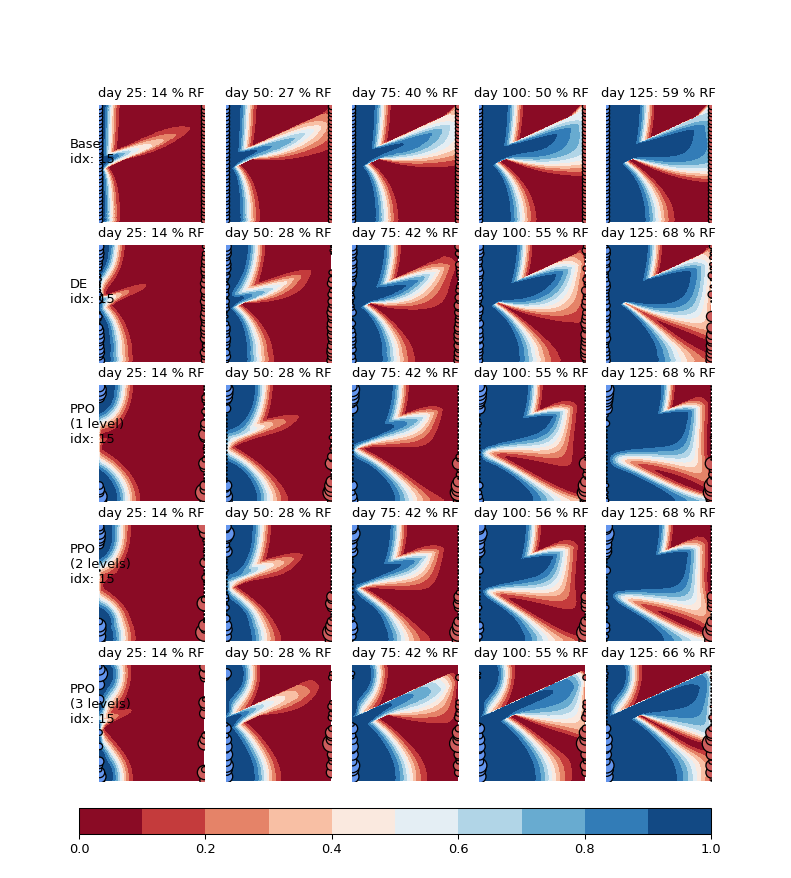

In [9]:
# plot actions (well schedules)
for i,(r_array, a_array, s_array, case_names) in enumerate(zip(r_array_eval, a_array_eval, s_array_eval, case_names_eval)):
    fig = plot_actions(r_array, a_array, s_array, case_names,
                 s_min=0, s_max=1, 
                 levels=10, show_wells=True, marker_size_ref=5,
                 time_per_step=25, time_unit='day')
    fig.savefig(data_dir+'/'+case+'_a_eval_'+str(i)+'.pdf')